## This challenge consists of three problems:
## 1. What variables influence the Conversation Result to generate a positive outcome? How would you measure the impact of each variable on the result? What hypotheses can you extract from this analysis and what experiments would you suggest to increase the likelihood of positive conversation results?  
## 2. Build a supervised learning model to predict the Conversation Result. Present a way to evaluate this model.  
## 3. What insights related to user’s engagement with the app can you extract from the data? What clusters of users do have the highest engagement rate?

## Part 1 Feature engineering

### At first, load the csv file

In [1]:
import pandas as pd
import numpy as np

In [2]:
conversation_data_path = './conversation.csv'
users_data_path = './users.csv'

In [3]:
conversation_data = pd.read_csv(conversation_data_path)
users_data = pd.read_csv(users_data_path)

### Take a glance of both conversation_data and users_data

In [4]:
conversation_data.head()

,index,$os,conversation_duration,timestamp,emotion,emotion_level,conversation_result,thinking_traps,factors,distinct_id
0,0,iOS,426,2018-10-02T00:00:10,tiredness,60.0,Positive,[],"['Sedentary', 'Being by myself', 'Home']",0D0BDF421B6A4E8DAACF2734E2376791
1,1,iOS,521,2018-10-02T00:01:25,depression,100.0,NaN,[],"['Family', 'Colleagues', 'Work', 'Home']",C601BCA939664B5D970409B43C2927EF
2,2,iOS,805,2018-10-02T00:01:50,insecurity,50.0,Negative,"['What if Loop', 'Negative Glasses', 'Mind Rea...","['Colleagues', 'Work']",A1C2E7E7DB854B038E9D0CE0622820BD
3,3,iOS,392,2018-10-02T00:02:02,tiredness,75.0,Negative,[],[],5613AB8F803543E58981AA7FB214CE32
4,4,Android,562,2018-10-02T00:02:34,stress,90.0,NaN,"['Blaming', 'Should Thinking', 'Catastrophic T...",['Finances'],FFC4648F36324B2DB128FC043BC64A9E


In [5]:
print('NaN number in conversation_duration is: ', sum(pd.isnull(conversation_data.conversation_duration)))
print('NaN number in timestamp is: ', sum(pd.isnull(conversation_data.timestamp)))
print('NaN number in emotion_level is: ', sum(pd.isnull(conversation_data.emotion_level)))
print('NaN number in convseration_result is: ', sum(pd.isnull(conversation_data.conversation_result)))

('NaN number in conversation_duration is: ', 0)
('NaN number in timestamp is: ', 0)
('NaN number in emotion_level is: ', 0)
('NaN number in convseration_result is: ', 42427)


## There are significant number of cases the user did not provide feedback on conversation_result.

In [6]:
users_data.head()

,index,$distinct_id,age,daily_notification,gender,occupation,personality_type
0,0,E185ACD01070418FAC3A34186C1C00B1,22,NaN,male,Student full time,ENFPT
1,1,2921AB4622F14F548E5285C72AD4D984,28,21:30,male,Student full time,INFPA
2,2,03D71DB1C8934F13B45D3724FD1A2317,44,NaN,male,Work and attend school,INTJT
3,3,35E2C305385B49CB8BCB338FB2C2E648,39,NaN,female,Employed full time,INTPT
4,4,F4D57C4A448F4F3F885B7C5722B1207D,27,12:30,male,Freelancer or work part time,INFJT


In [7]:
print('NaN number in age is: ', sum(pd.isnull(users_data.age)))
print('NaN number in daily_notification is: ', sum(pd.isnull(users_data.daily_notification)))
print('NaN number in gender is: ', sum(pd.isnull(users_data.gender)))
print('NaN number in occupation is: ', sum(pd.isnull(users_data.occupation)))
print('NaN number in personality_type is: ', sum(pd.isnull(users_data.personality_type)))

('NaN number in age is: ', 0)
('NaN number in daily_notification is: ', 55755)
('NaN number in gender is: ', 0)
('NaN number in occupation is: ', 5078)
('NaN number in personality_type is: ', 9292)


Check how many samples in conversation_data.

In [8]:
print(conversation_data.shape)

(160968, 10)


check how many samples in users_data

In [9]:
print(users_data.shape)

(85068, 7)


### The features can be categorized into three types: numerical type, categorical type and time type.   
### 1. \$os, emotion, conversation_result, thinking_traps, factors and distinct_id in conversation_data, gender, occupation, personality_type and \\$distinct_id in users_data are categorical type features.  
### 2. timestamp and daily_notification are time type features (str type feature)
### 3. Others are numerical features. 

rename some of the column name in the dataframe.

In [10]:
users_data_v1 = users_data.rename({'$distinct_id':'distinct_id'}, axis='columns')

In [11]:
conversation_data_v1 = conversation_data.rename({'$os':'os'}, axis='columns')

left_merge conversation_data_v1 table with users_data_v1.

In [12]:
df = conversation_data_v1.merge(users_data_v1, how='left', on=['distinct_id'], indicator=True)

In [13]:
df.head()

,index_x,os,conversation_duration,timestamp,emotion,emotion_level,conversation_result,thinking_traps,factors,distinct_id,index_y,age,daily_notification,gender,occupation,personality_type,_merge
0,0,iOS,426,2018-10-02T00:00:10,tiredness,60.0,Positive,[],"['Sedentary', 'Being by myself', 'Home']",0D0BDF421B6A4E8DAACF2734E2376791,64512.0,26.0,NaN,female,Student full time,INTJA,both
1,1,iOS,521,2018-10-02T00:01:25,depression,100.0,NaN,[],"['Family', 'Colleagues', 'Work', 'Home']",C601BCA939664B5D970409B43C2927EF,47163.0,20.0,NaN,female,NaN,NaN,both
2,2,iOS,805,2018-10-02T00:01:50,insecurity,50.0,Negative,"['What if Loop', 'Negative Glasses', 'Mind Rea...","['Colleagues', 'Work']",A1C2E7E7DB854B038E9D0CE0622820BD,44548.0,35.0,06:00,male,Employed full time,ENFJT,both
3,3,iOS,392,2018-10-02T00:02:02,tiredness,75.0,Negative,[],[],5613AB8F803543E58981AA7FB214CE32,52175.0,18.0,NaN,male,Student full time,INFJA,both
4,4,Android,562,2018-10-02T00:02:34,stress,90.0,NaN,"['Blaming', 'Should Thinking', 'Catastrophic T...",['Finances'],FFC4648F36324B2DB128FC043BC64A9E,71752.0,42.0,NaN,male,Freelancer or work part time,ENFJT,both


Build a new dataframe showing  how many samples in conversation_data_v1 have no user information.

In [14]:
df_no_user = df[df['_merge'] == 'left_only']

In [15]:
df_no_user.head()

,index_x,os,conversation_duration,timestamp,emotion,emotion_level,conversation_result,thinking_traps,factors,distinct_id,index_y,age,daily_notification,gender,occupation,personality_type,_merge
560,560,iOS,486,2018-10-02T06:37:50,tiredness,30.0,Positive,[],"['Bad Sleep', 'Being by myself', 'Finances', '...",0E5AD6F57E89423AA52CB0B2C62ACE9B,NaN,NaN,NaN,NaN,NaN,NaN,left_only
1095,1095,iOS,677,2018-10-02T13:34:12,insecurity,75.0,Positive,"['Perfectionism', 'Negative Glasses', 'Catastr...","['Being by myself', 'Family', 'Friends', 'Coll...",CBB5AC03D938418C9C6E9BE9A734B04A,NaN,NaN,NaN,NaN,NaN,NaN,left_only
3683,3683,iOS,1151,2018-10-03T15:57:13,anxiety,85.0,Negative,"['Blaming', 'Overgeneralization', 'What if Loo...","['Bad Sleep', 'Being by myself', 'Family', 'Fr...",23CE964AEF7448F88B585EC4924A6008,NaN,NaN,NaN,NaN,NaN,NaN,left_only
6472,6472,Android,389,2018-10-04T20:15:24,tiredness,80.0,NaN,[],[],E9A1F938C76848CB913455C51B765446,NaN,NaN,NaN,NaN,NaN,NaN,left_only
6732,6732,iOS,627,2018-10-04T22:50:19,numbness,60.0,Negative,[],"['Bad Sleep', 'Friends', 'Work']",6D3F974F5AAD4E8C91027BA583F62205,NaN,NaN,NaN,NaN,NaN,NaN,left_only


In [16]:
print(df_no_user.shape)

(1798, 17)


In [17]:
print((1798+0.0)/160968)

0.0111699219721


### About 1% of conversation_data_v1 has no user information. So how does the age, gendar and personality_type affect the conversation_results?

Write my own labelencoder, which can handle NaN variables.

In [18]:
class newLabelEncoder(object):
    
    def __init__(self, key_name):
        self.key_name = key_name
        
    def fit(self, X, y=None):
        #input X is series
        self.keys = set(X)
        num = 0
        self.dict = {}
        for item in self.keys:
            self.dict[item] = num
            num += 1
        self.max_num = num + 1
        
    
    def transform(self, X, y=None):
        res = {self.key_name: []}  
        for item in X:
            if item in self.keys:
                res[self.key_name].append(self.dict[item])
            else:
                res[self.key_name].append(self.max_num)
        return pd.DataFrame(res)
    
    def fit_transform(self, X, y=None):
        self.fit(X)
        return self.transform(X)

Drop the samples without user information.

In [19]:
df_temp = df.dropna(subset=['index_y'])
df_temp.reset_index(drop=True, inplace=True)

In [20]:
df_temp.head()

,index_x,os,conversation_duration,timestamp,emotion,emotion_level,conversation_result,thinking_traps,factors,distinct_id,index_y,age,daily_notification,gender,occupation,personality_type,_merge
0,0,iOS,426,2018-10-02T00:00:10,tiredness,60.0,Positive,[],"['Sedentary', 'Being by myself', 'Home']",0D0BDF421B6A4E8DAACF2734E2376791,64512.0,26.0,NaN,female,Student full time,INTJA,both
1,1,iOS,521,2018-10-02T00:01:25,depression,100.0,NaN,[],"['Family', 'Colleagues', 'Work', 'Home']",C601BCA939664B5D970409B43C2927EF,47163.0,20.0,NaN,female,NaN,NaN,both
2,2,iOS,805,2018-10-02T00:01:50,insecurity,50.0,Negative,"['What if Loop', 'Negative Glasses', 'Mind Rea...","['Colleagues', 'Work']",A1C2E7E7DB854B038E9D0CE0622820BD,44548.0,35.0,06:00,male,Employed full time,ENFJT,both
3,3,iOS,392,2018-10-02T00:02:02,tiredness,75.0,Negative,[],[],5613AB8F803543E58981AA7FB214CE32,52175.0,18.0,NaN,male,Student full time,INFJA,both
4,4,Android,562,2018-10-02T00:02:34,stress,90.0,NaN,"['Blaming', 'Should Thinking', 'Catastrophic T...",['Finances'],FFC4648F36324B2DB128FC043BC64A9E,71752.0,42.0,NaN,male,Freelancer or work part time,ENFJT,both


### First, check if there is NaN value in thinking_traps column or factors column.

In [21]:
print('NaN number in thinking_traps is: ', sum(pd.isnull(df_temp.thinking_traps)))
print('NaN number in factors is: ', sum(pd.isnull(df_temp.factors)))

('NaN number in thinking_traps is: ', 14)
('NaN number in factors is: ', 1)


Check how many samples in df_temp

In [22]:
print(df_temp.shape)

(159170, 17)


Since only very small amount of samples has NaN values in thinking_traps or factors,  remove these samples.

In [23]:
df_temp1 = df_temp.dropna(subset=['thinking_traps'])
df_remove_no_user = df_temp1.dropna(subset=['factors'])
del df_temp1
df_remove_no_user.reset_index(drop=True, inplace=True)

In [24]:
print('NaN number in thinking_traps is: ', sum(pd.isnull(df_remove_no_user.thinking_traps)))
print('NaN number in factors is: ', sum(pd.isnull(df_remove_no_user.factors)))

('NaN number in thinking_traps is: ', 0)
('NaN number in factors is: ', 0)


In [25]:
df_remove_no_user.head()

,index_x,os,conversation_duration,timestamp,emotion,emotion_level,conversation_result,thinking_traps,factors,distinct_id,index_y,age,daily_notification,gender,occupation,personality_type,_merge
0,0,iOS,426,2018-10-02T00:00:10,tiredness,60.0,Positive,[],"['Sedentary', 'Being by myself', 'Home']",0D0BDF421B6A4E8DAACF2734E2376791,64512.0,26.0,NaN,female,Student full time,INTJA,both
1,1,iOS,521,2018-10-02T00:01:25,depression,100.0,NaN,[],"['Family', 'Colleagues', 'Work', 'Home']",C601BCA939664B5D970409B43C2927EF,47163.0,20.0,NaN,female,NaN,NaN,both
2,2,iOS,805,2018-10-02T00:01:50,insecurity,50.0,Negative,"['What if Loop', 'Negative Glasses', 'Mind Rea...","['Colleagues', 'Work']",A1C2E7E7DB854B038E9D0CE0622820BD,44548.0,35.0,06:00,male,Employed full time,ENFJT,both
3,3,iOS,392,2018-10-02T00:02:02,tiredness,75.0,Negative,[],[],5613AB8F803543E58981AA7FB214CE32,52175.0,18.0,NaN,male,Student full time,INFJA,both
4,4,Android,562,2018-10-02T00:02:34,stress,90.0,NaN,"['Blaming', 'Should Thinking', 'Catastrophic T...",['Finances'],FFC4648F36324B2DB128FC043BC64A9E,71752.0,42.0,NaN,male,Freelancer or work part time,ENFJT,both


Cast emotion_level, index_y and age to int type.

In [26]:
df_remove_no_user['emotion_level'] = df_remove_no_user['emotion_level'].map(lambda x: int(x))
df_remove_no_user['index_y'] = df_remove_no_user['index_y'].map(lambda x: int(x))
df_remove_no_user['age'] = df_remove_no_user['age'].map(lambda x: int(x))

In [27]:
df_remove_no_user.head()

,index_x,os,conversation_duration,timestamp,emotion,emotion_level,conversation_result,thinking_traps,factors,distinct_id,index_y,age,daily_notification,gender,occupation,personality_type,_merge
0,0,iOS,426,2018-10-02T00:00:10,tiredness,60,Positive,[],"['Sedentary', 'Being by myself', 'Home']",0D0BDF421B6A4E8DAACF2734E2376791,64512,26,NaN,female,Student full time,INTJA,both
1,1,iOS,521,2018-10-02T00:01:25,depression,100,NaN,[],"['Family', 'Colleagues', 'Work', 'Home']",C601BCA939664B5D970409B43C2927EF,47163,20,NaN,female,NaN,NaN,both
2,2,iOS,805,2018-10-02T00:01:50,insecurity,50,Negative,"['What if Loop', 'Negative Glasses', 'Mind Rea...","['Colleagues', 'Work']",A1C2E7E7DB854B038E9D0CE0622820BD,44548,35,06:00,male,Employed full time,ENFJT,both
3,3,iOS,392,2018-10-02T00:02:02,tiredness,75,Negative,[],[],5613AB8F803543E58981AA7FB214CE32,52175,18,NaN,male,Student full time,INFJA,both
4,4,Android,562,2018-10-02T00:02:34,stress,90,NaN,"['Blaming', 'Should Thinking', 'Catastrophic T...",['Finances'],FFC4648F36324B2DB128FC043BC64A9E,71752,42,NaN,male,Freelancer or work part time,ENFJT,both


In [28]:
type(df_remove_no_user.timestamp[0])

str

### Convert conversation_result into numerical values.

In [29]:
label_conversation_result = newLabelEncoder('conversation_reslt2num')

In [30]:
conversation_result2num = label_conversation_result.fit_transform(df_remove_no_user.conversation_result)

In [31]:
conversation_result2num.head()

,conversation_reslt2num
0,1
1,0
2,2
3,2
4,0


In [32]:
print(label_conversation_result.dict)

{nan: 0, 'Positive': 1, 'Negative': 2}


For daily_notification, it indicates the customer's engagement to the app.  Use 0 for NaN value, 1 otherwise.

In [33]:
daily_notification2num = df_remove_no_user.daily_notification.map(lambda x: 0 if type(x) == float else 1)

In [34]:
daily_notification2num[:5]

0    0
1    0
2    1
3    0
4    0
Name: daily_notification, dtype: int64

Create a dummy_transformer.

In [35]:
class Dummy_Transformer(object):
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        self.keys = set(X)
    
    def transform(self, X, y=None):
        res = {}
        for key in self.keys:
            res[key] = [0]*len(X)    
        for i, item in enumerate(X):
            if item in self.keys:
                res[item][i] = 1
        return pd.DataFrame(res)
    
    def fit_transform(self, X, y=None):
        self.fit(X)
        return self.transform(X)     

In [36]:
temp_transformer = Dummy_Transformer()

In [37]:
emotion_value = temp_transformer.fit_transform(df_remove_no_user.emotion)

In [38]:
print(temp_transformer.keys)

set(['stress', 'anxiety', 'tiredness', 'numbness', 'insecurity', 'envy', 'shame', 'sadness', 'boredom', 'frustration', 'anger', 'fear', 'disgust', 'depression'])


In [39]:
temp_transformer = Dummy_Transformer()

In [40]:
gender_value = temp_transformer.fit_transform(df_remove_no_user.gender)
print(temp_transformer.keys)

set(['male', 'female'])


In [41]:
temp_transformer = Dummy_Transformer()
occupation_value = temp_transformer.fit_transform(df_remove_no_user.occupation)
print(temp_transformer.keys)

set([nan, 'Work and attend school', 'Retired', 'Unemployed', 'Employed full time', 'Student full time', 'not_informed', 'Freelancer or work part time', 'Homemaker'])


In [42]:
temp_transformer = Dummy_Transformer()
personality_type_value = temp_transformer.fit_transform(df_remove_no_user.personality_type)
print(temp_transformer.keys)

set([nan, 'ENFPT', 'ISTPT', 'ISTJA', 'ISTPA', 'ENFPA', 'ISTJT', 'ISFPA', 'ESFJA', 'ESFPT', 'INFJA', 'ENTJA', 'ENTPT', 'INFJT', 'ESFPA', 'ESTPA', 'ENTPA', 'ENTJT', 'ESTPT', 'ENFJA', 'ISFPT', 'ESTJA', 'ESTJT', 'ENFJT', 'ESFJT', 'INFPT', 'ISFJT', 'INTPT', 'INTJA', 'INTJT', 'ISFJA', 'INFPA', 'INTPA'])


thinking_traps and factors are list of string. 

In [43]:
import re

In [44]:
class Dummy_List_Transformer(object):
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        self.keys = set()
        self.empty_value = 'empty'
        for item in X:
            temp_list =  re.findall(r"'([^']*)'", item)
            if len(temp_list) == 0:
                self.keys.add(self.empty_value)
            else:
                self.keys.update(temp_list)
                
            
    
    def transform(self, X, y=None):
        res = {}
        for key in self.keys:
            res[key] = [0]*len(X)    
        for i, item in enumerate(X):
            temp_list = re.findall(r"'([^']*)'", item)
            if len(temp_list) == 0:
                res[self.empty_value][i] = 1
            else:
                for element in temp_list:
                    if element in self.keys:
                        res[element][i] = 1
        return pd.DataFrame(res)
    
    def fit_transform(self, X, y=None):
        self.fit(X)
        return self.transform(X)     

In [45]:
dummy_tf = Dummy_List_Transformer()
temp_thinking_traps = dummy_tf.fit_transform(df_remove_no_user.thinking_traps)

In [46]:
temp_thinking_traps.head()

,All-or-Nothing Thinking,Blaming,Catastrophic Thinking,Fortune Telling,Labeling,Mind Reading,Negative Glasses,Negative Memory,Not Accepting,Overgeneralization,Perfectionism,Personalization,Should Thinking,What if Loop,empty
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,0,0,0,0,1,1,1,0,1,1,0,0,1,1,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
4,0,1,1,0,1,1,0,1,0,0,1,1,1,0,0


In [47]:
dummy_tf = Dummy_List_Transformer()
temp_factors = dummy_tf.fit_transform(df_remove_no_user.factors)

In [48]:
temp_factors.head()

,Alcohol,Bad Sleep,Being by myself,Binging,Books,Caffeine,Colleagues,Date,Dieting,Exercise,...,Shopping,Social Media,Socializing,Sports,Tobacco,Travel,Veggie,Weight,Work,empty
0,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Part 2 Find which feature(s) affect conversation_result

### 2.1 Check numerical type features.

***age feature***

In [49]:
temp = df_remove_no_user[pd.isnull(df_remove_no_user.conversation_result)].age

In [50]:
temp_age_nan = temp.reset_index(drop=True)
temp_age_nan[:5]

0    20
1    42
2    19
3    21
4    19
Name: age, dtype: int64

In [51]:
temp = df_remove_no_user[df_remove_no_user.conversation_result == 'Positive'].age
temp_age_positive = temp.reset_index(drop=True)
temp_age_positive[:5]

0    26
1    29
2    28
3    25
4    18
Name: age, dtype: int64

In [52]:
temp = df_remove_no_user[df_remove_no_user.conversation_result == 'Negative'].age
temp_age_negative = temp.reset_index(drop=True)
temp_age_negative[:5]

0    35
1    18
2    42
3    23
4    34
Name: age, dtype: int64

In [53]:
import matplotlib.pyplot as plt
%matplotlib inline 

In [54]:
print('max is : ', df_remove_no_user.age.max(), ' min is: ', df_remove_no_user.age.min())

('max is : ', 85, ' min is: ', 18)


Plot histogram of ages for different conversation_result

In [ ]:
bins = np.linspace(10, 90, 20)
plt.hist(temp_age_nan, bins, alpha=0.5, density=True, label='nan')
plt.hist(temp_age_positive, bins, alpha=0.5, density=True, label='Positive')
plt.hist(temp_age_negative, bins, alpha=0.5, density=True, label='Negative')
plt.legend(loc='upper right')
plt.show()

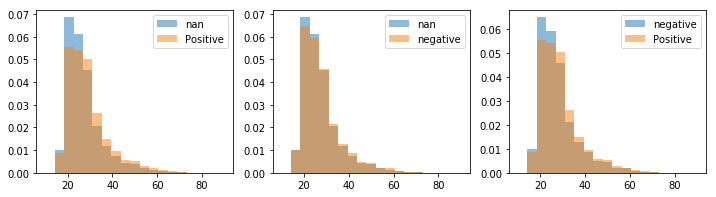

In [55]:
f = plt.figure(figsize=(12,3))
ax1 = f.add_subplot(131)
ax2 = f.add_subplot(132)
ax3 = f.add_subplot(133)
bins = np.linspace(10, 90, 20)
ax1.hist(temp_age_nan, bins, alpha=0.5, density=True, label='nan')
ax1.hist(temp_age_positive, bins, alpha=0.5, density=True, label='Positive')
ax1.legend(loc='upper right')

ax2.hist(temp_age_nan, bins, alpha=0.5, density=True, label='nan')
ax2.hist(temp_age_negative, bins, alpha=0.5, density=True, label='negative')
ax2.legend(loc='upper right')

ax3.hist(temp_age_negative, bins, alpha=0.5, density=True, label='negative')
ax3.hist(temp_age_positive, bins, alpha=0.5, density=True, label='Positive')
ax3.legend(loc='upper right')

### Based on the histogram, the age distribution for three conversation_result is very similar. 

***conversation_duration***

In [56]:
temp = df_remove_no_user[pd.isnull(df_remove_no_user.conversation_result)].conversation_duration
temp_duration_nan = temp.reset_index(drop=True)

temp = df_remove_no_user[df_remove_no_user.conversation_result == 'Positive'].conversation_duration
temp_duration_positive = temp.reset_index(drop=True)

temp = df_remove_no_user[df_remove_no_user.conversation_result == 'Negative'].conversation_duration
temp_duration_negative = temp.reset_index(drop=True)

In [57]:
temp_duration_positive.min()

-86095

In [58]:
sum(conversation_data.conversation_duration < 0)

1

In [59]:
sum(conversation_data.conversation_duration > 3600*24*3)

1

In [60]:
sum(conversation_data.conversation_duration <3600)

156830

In [61]:
df_remove_no_user.shape

(159156, 17)

In [62]:
sum(df_remove_no_user.conversation_duration < 3600)

155056

In [63]:
print('max is : ', df_remove_no_user.conversation_duration.max(),
      ' min is: ', df_remove_no_user.conversation_duration.min())

('max is : ', 9842884, ' min is: ', -86095)


Obviously, the max value and min value was recorded wrong. Since there are only two extreme outliers,  it will have insignificant influence.

In [64]:
bins = np.linspace(0, 3600, 100)

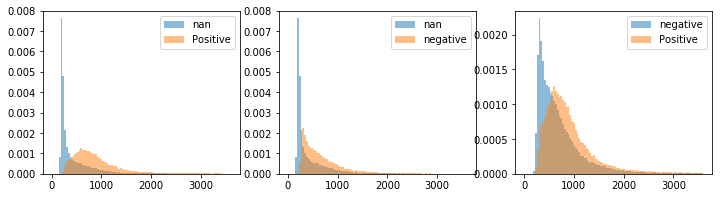

In [65]:
f = plt.figure(figsize=(12,3))
ax1 = f.add_subplot(131)
ax2 = f.add_subplot(132)
ax3 = f.add_subplot(133)

ax1.hist(temp_duration_nan, bins, alpha=0.5, density=True, label='nan')
ax1.hist(temp_duration_positive, bins, alpha=0.5, density=True, label='Positive')
ax1.legend(loc='upper right')

ax2.hist(temp_duration_nan, bins, alpha=0.5, density=True, label='nan')
ax2.hist(temp_duration_negative, bins, alpha=0.5, density=True, label='negative')
ax2.legend(loc='upper right')

ax3.hist(temp_duration_negative, bins, alpha=0.5, density=True, label='negative')
ax3.hist(temp_duration_positive, bins, alpha=0.5, density=True, label='Positive')
ax3.legend(loc='upper right')

## <span style="color:red">The distribution of conversation_duration is significantly different for three conversation_results.</span>

In [66]:
from sklearn.preprocessing import label_binarize

In [67]:
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier

## Part 2.2 check categorical type features

*Use occupation_value for prediction*

In [68]:
kf = KFold(n_splits=5)
auc_value_list = []

In [69]:
y_value = label_binarize(conversation_result2num, classes=[0, 1, 2])

In [70]:
n_classes = y_value.shape[1]

In [71]:
LR = LogisticRegression()

In [72]:
train_raw = occupation_value.copy()

In [73]:
classifier = OneVsRestClassifier(LogisticRegression(n_jobs=-1))

In [74]:
pred_y_value = np.zeros((y_value.shape[0], y_value.shape[1]))
for train_index, valid_index in kf.split(train_raw.iloc[:,:]):
    X_train, X_valid = train_raw.iloc[train_index, :], train_raw.iloc[valid_index, :]
    y_train, y_valid = y_value[train_index, :], y_value[valid_index, :]
    classifier.fit(X_train, y_train)
    pred_y_value[valid_index, :] = classifier.predict_proba(X_valid)
        
for i in range(n_classes):
    auc_value_list.append(roc_auc_score(y_value[:,i], pred_y_value[:,i]))

C:\Anaconda\lib\site-packages\sklearn\linear_model\logistic.py:1232: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))


In [75]:
print(pred_y_value[2,:])

[0.24315339 0.46244569 0.29440684]


In [76]:
print(auc_value_list)

[0.525271999150851, 0.540682164882007, 0.5122420738771626]


The prediction based on occupation value is close to random guess value, which is 0.5.

*use personality_type_value*

In [77]:
kf = KFold(n_splits=5)
auc_value_list = []
train_raw = personality_type_value.copy()
classifier = OneVsRestClassifier(LogisticRegression(n_jobs=-1))

In [78]:
pred_y_value = np.zeros((y_value.shape[0], y_value.shape[1]))
for train_index, valid_index in kf.split(train_raw.iloc[:,:]):
    X_train, X_valid = train_raw.iloc[train_index, :], train_raw.iloc[valid_index, :]
    y_train, y_valid = y_value[train_index, :], y_value[valid_index, :]
    classifier.fit(X_train, y_train)
    pred_y_value[valid_index, :] = classifier.predict_proba(X_valid)
        
for i in range(n_classes):
    auc_value_list.append(roc_auc_score(y_value[:,i], pred_y_value[:,i]))

In [79]:
print(auc_value_list)

[0.5138890551329537, 0.5502136054907102, 0.5246035207407727]


The prediction based on personality_type value is close to random guess value, which is 0.5.

*use gender value*

In [80]:
kf = KFold(n_splits=5)
auc_value_list = []
train_raw = gender_value.copy()
classifier = OneVsRestClassifier(LogisticRegression(n_jobs=-1))

In [81]:
pred_y_value = np.zeros((y_value.shape[0], y_value.shape[1]))
for train_index, valid_index in kf.split(train_raw.iloc[:,:]):
    X_train, X_valid = train_raw.iloc[train_index, :], train_raw.iloc[valid_index, :]
    y_train, y_valid = y_value[train_index, :], y_value[valid_index, :]
    classifier.fit(X_train, y_train)
    pred_y_value[valid_index, :] = classifier.predict_proba(X_valid)
        
for i in range(n_classes):
    auc_value_list.append(roc_auc_score(y_value[:,i], pred_y_value[:,i]))

In [82]:
print(auc_value_list)

[0.46756254576648304, 0.504669800746364, 0.5005538818992489]


Use gender value for prediction, very close to random guess.

*use thinking_traps value*

In [83]:
kf = KFold(n_splits=5)
auc_value_list = []
train_raw = temp_thinking_traps.copy()
classifier = OneVsRestClassifier(LogisticRegression(n_jobs=-1))

In [84]:
pred_y_value = np.zeros((y_value.shape[0], y_value.shape[1]))
for train_index, valid_index in kf.split(train_raw.iloc[:,:]):
    X_train, X_valid = train_raw.iloc[train_index, :], train_raw.iloc[valid_index, :]
    y_train, y_valid = y_value[train_index, :], y_value[valid_index, :]
    classifier.fit(X_train, y_train)
    pred_y_value[valid_index, :] = classifier.predict_proba(X_valid)
        
for i in range(n_classes):
    auc_value_list.append(roc_auc_score(y_value[:,i], pred_y_value[:,i]))

In [85]:
print(auc_value_list)

[0.621144221903642, 0.6211912145122213, 0.5079764041384575]


thinking_traps has some effect on conversation_result.

*use factors value*

In [86]:
kf = KFold(n_splits=5)
auc_value_list = []
train_raw = temp_factors.copy()
classifier = OneVsRestClassifier(LogisticRegression(n_jobs=-1))

In [87]:
pred_y_value = np.zeros((y_value.shape[0], y_value.shape[1]))
for train_index, valid_index in kf.split(train_raw.iloc[:,:]):
    X_train, X_valid = train_raw.iloc[train_index, :], train_raw.iloc[valid_index, :]
    y_train, y_valid = y_value[train_index, :], y_value[valid_index, :]
    classifier.fit(X_train, y_train)
    pred_y_value[valid_index, :] = classifier.predict_proba(X_valid)
        
for i in range(n_classes):
    auc_value_list.append(roc_auc_score(y_value[:,i], pred_y_value[:,i]))

In [88]:
print(auc_value_list)

[0.6030263560685437, 0.5910066429491164, 0.5648347824137204]


factors has some effect on conversation_result.

### emotion and emotion_level are closely related. 

In [89]:
df_temp = pd.concat([emotion_value, df_remove_no_user[['emotion_level']]], axis=1)

In [90]:
df_temp.head()

,anger,anxiety,boredom,depression,disgust,envy,fear,frustration,insecurity,numbness,sadness,shame,stress,tiredness,emotion_level
0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,60
1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,100
2,0,0,0,0,0,0,0,0,1,0,0,0,0,0,50
3,0,0,0,0,0,0,0,0,0,0,0,0,0,1,75
4,0,0,0,0,0,0,0,0,0,0,0,0,1,0,90


In [98]:
kf = KFold(n_splits=5)
auc_value_list = []
train_raw = df_temp.copy()
classifier = OneVsRestClassifier(LogisticRegression(n_jobs=-1))

In [99]:
pred_y_value = np.zeros((y_value.shape[0], y_value.shape[1]))
for train_index, valid_index in kf.split(train_raw.iloc[:,:]):
    X_train, X_valid = train_raw.iloc[train_index, :], train_raw.iloc[valid_index, :]
    y_train, y_valid = y_value[train_index, :], y_value[valid_index, :]
    classifier.fit(X_train, y_train)
    pred_y_value[valid_index, :] = classifier.predict_proba(X_valid)
        
for i in range(n_classes):
    auc_value_list.append(roc_auc_score(y_value[:,i], pred_y_value[:,i]))

In [100]:
print(auc_value_list)

[0.6009024891568723, 0.6129733515793547, 0.6169923690046916]


As we can see, emotion and emotion level they collectively affect the conversaion result.

## Part 3 Build the model

## Based on the analysis above,  I will use thinking_traps, factors, emtion, emtion_levels, and conversation_duration as features to predict conversation_result. 

In [105]:
df_temp = pd.concat([temp_thinking_traps, temp_factors, emotion_value, 
                     df_remove_no_user[['emotion_level']], df_remove_no_user[['conversation_duration']]], axis=1)

In [106]:
df_temp.head()

,All-or-Nothing Thinking,Blaming,Catastrophic Thinking,Fortune Telling,Labeling,Mind Reading,Negative Glasses,Negative Memory,Not Accepting,Overgeneralization,...,fear,frustration,insecurity,numbness,sadness,shame,stress,tiredness,emotion_level,conversation_duration
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,60,426
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,100,521
2,0,0,0,0,1,1,1,0,1,1,...,0,0,1,0,0,0,0,0,50,805
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,75,392
4,0,1,1,0,1,1,0,1,0,0,...,0,0,0,0,0,0,1,0,90,562


## 3.1 Use RandomForestClassifier

In [110]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

change the column name here.

In [111]:
train_raw = df_temp.copy()
y_value = conversation_result2num.conversation_reslt2num

In [112]:
kf = KFold(n_splits=5)
accuracy_score_list = []
n_estimators_list = range(20,400,30)
for n_estimator_value in n_estimators_list:
    pred_y_value= np.zeros(len(y_value))
    model = RandomForestClassifier(random_state=299, n_estimators=n_estimator_value, n_jobs=-1)
    for train_index, valid_index in kf.split(train_raw.iloc[:,:]):
        X_train, X_valid = train_raw.iloc[train_index, :], train_raw.iloc[valid_index,:]
        y_train, y_valid = y_value[train_index], y_value[valid_index]
        model.fit(X_train, y_train)
        pred_y_value[valid_index] = model.predict(X_valid)
    accuracy_score_list.append(accuracy_score(y_value, pred_y_value))

Text(0.5,1,'accuracy score as a function of n_estimators')

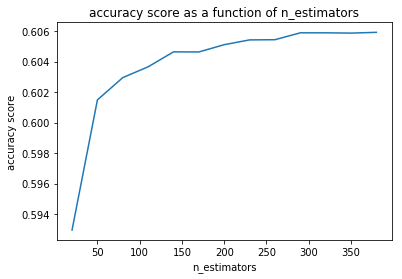

In [113]:
plt.plot(n_estimators_list, accuracy_score_list)
plt.xlabel('n_estimators')
plt.ylabel('accuracy score')
plt.title('accuracy score as a function of n_estimators')

pick n_estimators = 150

In [114]:
model = RandomForestClassifier(random_state=299, n_estimators=150, n_jobs=-1)
model.fit(train_raw, y_value)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=150, n_jobs=-1,
            oob_score=False, random_state=299, verbose=0, warm_start=False)

In [116]:
feature_list = list(train_raw.columns)
type(feature_list)

list

In [117]:
print(feature_list)

['All-or-Nothing Thinking', 'Blaming', 'Catastrophic Thinking', 'Fortune Telling', 'Labeling', 'Mind Reading', 'Negative Glasses', 'Negative Memory', 'Not Accepting', 'Overgeneralization', 'Perfectionism', 'Personalization', 'Should Thinking', 'What if Loop', 'empty', 'Alcohol', 'Bad Sleep', 'Being by myself', 'Binging', 'Books', 'Caffeine', 'Colleagues', 'Date', 'Dieting', 'Exercise', 'Family', 'Finances', 'Friends', 'Gaming', 'Good Sleep', 'Great meal', 'Health', 'Home', 'Insomnia', 'Junk food', 'Marijuana', 'Meat', 'Movies', 'Music', 'News', 'Online Videos', 'Outdoor', 'Outdoors', 'Pain', 'Partner', 'Period', 'Pre period', 'School', 'Sedentary', 'Shopping', 'Social Media', 'Socializing', 'Sports', 'Tobacco', 'Travel', 'Veggie', 'Weight', 'Work', 'empty', 'anger', 'anxiety', 'boredom', 'depression', 'disgust', 'envy', 'fear', 'frustration', 'insecurity', 'numbness', 'sadness', 'shame', 'stress', 'tiredness', 'emotion_level', 'conversation_duration']


In [126]:
def plot_feature_importance(model, feature_list):
    '''
    :type model: random forest tree model after fitting
    :type feature_list: list
    '''
    
    
    
    importance_pair = list(zip(feature_list, model.feature_importances_))
    

    importance_pair = sorted(importance_pair, key= lambda x: x[1])
    importance_pair = np.array(importance_pair)

    fig, ax = plt.subplots(figsize=(6, 25))
    #ax.xaxis.set_major_formatter(FormatStrFormatter('%.3f'))
    rects1 = ax.barh(importance_pair[:,0], importance_pair[:,1])
    ax.set_xlabel('Importance value')
    ax.set_title('Feature importance plot')
    ax.set_xticks([])  #test
    plt.xticks(rotation=90)

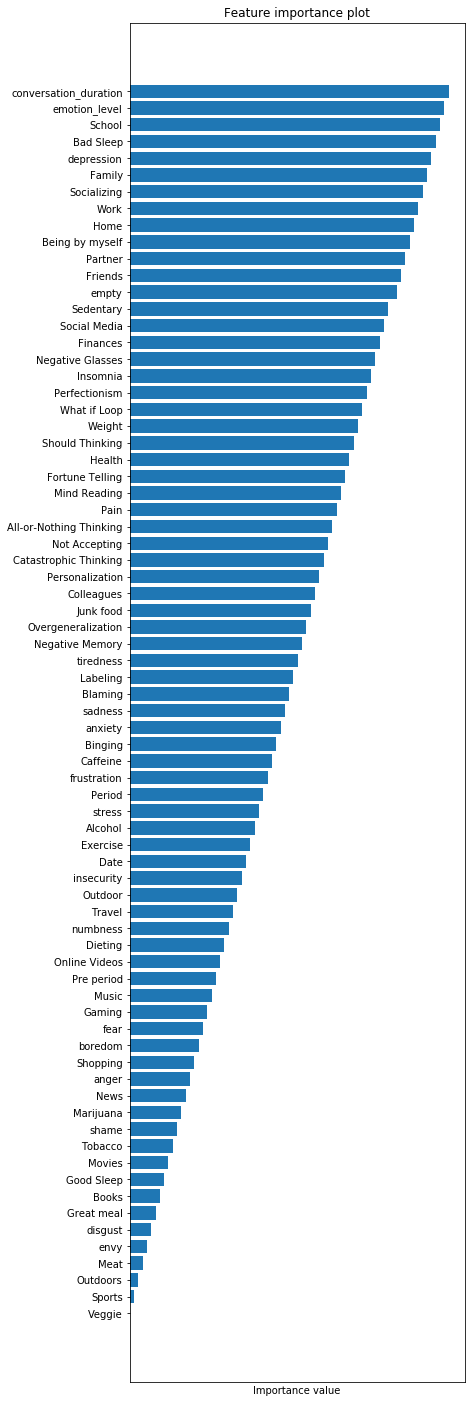

In [127]:
plot_feature_importance(model, feature_list)

In [128]:
print(temp_factors.columns)

Index([u'Alcohol', u'Bad Sleep', u'Being by myself', u'Binging', u'Books',
       u'Caffeine', u'Colleagues', u'Date', u'Dieting', u'Exercise', u'Family',
       u'Finances', u'Friends', u'Gaming', u'Good Sleep', u'Great meal',
       u'Health', u'Home', u'Insomnia', u'Junk food', u'Marijuana', u'Meat',
       u'Movies', u'Music', u'News', u'Online Videos', u'Outdoor', u'Outdoors',
       u'Pain', u'Partner', u'Period', u'Pre period', u'School', u'Sedentary',
       u'Shopping', u'Social Media', u'Socializing', u'Sports', u'Tobacco',
       u'Travel', u'Veggie', u'Weight', u'Work', u'empty'],
      dtype='object')


## 3.2 Analyze the results

## Based on the feature of importance plot, the top 10 are: conversation_duration, emotion_level, School (factors), Bad sleep (factor), depression (emotion), Family(factor), Socializing(factor), Work(factor), Home(factor), and Being myself(factor).  

## Question 1.<span style="color:blue">What variables influence the Conversation Result to generate a positive outcome? How would you measure the impact of each variable on the result? What hypotheses can you extract from this analysis and what experiments would you suggest to increase the likelihood of positive conversation results?</span>

## Although based on feature of importance, the top 10 features include conversation_duration, emotion_level,  which should be combined with emotion, and 8 from factor, only conversation_duration is independent of user's personal information. <span style="color:red">Increasing the conversation_duration is the way the app can do to increase positive conversation results.</span> 

## The experiments I suggest is 
## 1. Adding more content in the app so that the user can use longer time on the app
## 2. Have more personalized content, so for user with different personality (different factor, emotion, thinking_traps) will enjoy the content they see, have more interaction with the app.

## Question 2. <span style="color:blue">Build a supervised learning model to predict the Conversation Result. Present a way to evaluate this model</span>

In [132]:
kf = KFold(n_splits=5)
auc_value_list = []

In [133]:
y_value = label_binarize(conversation_result2num, classes=[0, 1, 2])
n_classes = y_value.shape[1]

In [134]:
classifier = OneVsRestClassifier(LogisticRegression(n_jobs=-1))

In [135]:
pred_y_value = np.zeros((y_value.shape[0], y_value.shape[1]))
for train_index, valid_index in kf.split(train_raw.iloc[:,:]):
    X_train, X_valid = train_raw.iloc[train_index, :], train_raw.iloc[valid_index, :]
    y_train, y_valid = y_value[train_index, :], y_value[valid_index, :]
    classifier.fit(X_train, y_train)
    pred_y_value[valid_index, :] = classifier.predict_proba(X_valid)
        
for i in range(n_classes):
    auc_value_list.append(roc_auc_score(y_value[:,i], pred_y_value[:,i]))

In [136]:
print(auc_value_list)

[0.7066052487847554, 0.7052567610321866, 0.6374388013180945]


## This is one vs all model, for conversation_result, the 1st item in the auc_value_list is NaN vs others; the 2nd item is Positive vs others; and the 3rd item is Negative vs others.

## I use auc to evaluate this model.

## Part 4 user’s engagement with the app

In [138]:
sum(pd.isnull(df_remove_no_user.daily_notification))

109023

In [140]:
print(df_remove_no_user.shape)

(159156, 17)


### I will use conversation_duration to measure the user's engagement with the app. The longer the time, the more engaged of the user. 

Based on previous calculation, 97% of users has conversation_duration time between 0 and 3600.  I will only consider the conversation_duration in the range.

In [142]:
df_temp = df_remove_no_user[(df_remove_no_user.conversation_duration>0) 
                            &(df_remove_no_user.conversation_duration<3600)]
df_temp.reset_index(drop=True, inplace=True)

Text(0,0.5,'conversation_duration')

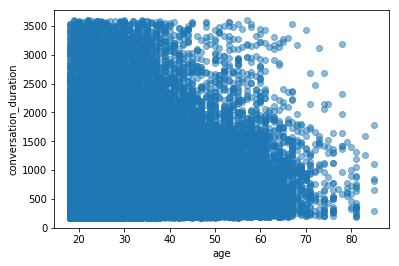

In [143]:
plt.scatter(df_temp.age, df_temp.conversation_duration, alpha=0.5)
plt.xlabel('age')
plt.ylabel('conversation_duration')

## For users younger than 40, they have higher chance to have longer conversation.

In [144]:
duration_male = df_temp[df_temp.gender == 'male'].conversation_duration
duration_male.reset_index(drop=True, inplace=True)

In [145]:
duration_female = df_temp[df_temp.gender == 'female'].conversation_duration
duration_female.reset_index(drop=True, inplace=True)

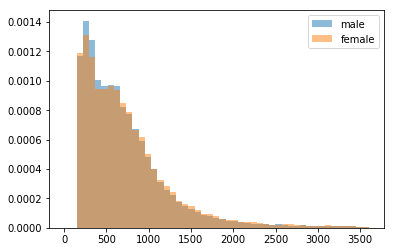

In [149]:
bins = np.linspace(0, 3600, 50)

plt.hist(duration_male, bins, density=True, alpha=0.5, label='male')
plt.hist(duration_female, bins, density=True, alpha=0.5, label='female')
plt.legend(loc='upper right')
plt.show()

## The gender has little effect on converation_duration. 

In [150]:
temp_transformer = Dummy_Transformer()
emotion_value1 = temp_transformer.fit_transform(df_temp.emotion)

temp_transformer = Dummy_Transformer()
occupation_value1 = temp_transformer.fit_transform(df_temp.occupation)

temp_transformer = Dummy_Transformer()
personality_type_value1 = temp_transformer.fit_transform(df_temp.personality_type)

In [151]:
from sklearn.ensemble import RandomForestRegressor

In [152]:
RF_regressor = RandomForestRegressor()

In [154]:
from sklearn.metrics import mean_squared_error, r2_score

In [155]:
mse = []
r2_score_value = []
train_raw = emotion_value1
y_value = df_temp.conversation_duration.copy()
pred_y_value= np.zeros(len(y_value))
model = RandomForestRegressor(random_state =299, 
                              n_estimators=200,
                              n_jobs=-1)
for train_index, valid_index in kf.split(train_raw.iloc[:,:]):
    X_train, X_valid = train_raw.iloc[train_index, :], train_raw.iloc[valid_index,:]
    y_train, y_valid = y_value[train_index], y_value[valid_index]
    model.fit(X_train, y_train)
    pred_y_value[valid_index] = model.predict(X_valid)
mse.append(mean_squared_error(y_value, pred_y_value))
r2_score_value.append(r2_score(y_value, pred_y_value))
print('mean square error is: {0: f}'.format(mse[0]))
print('r2 score value is: {0:f}'.format(r2_score_value[0]))

mean square error is:  259681.256145
r2 score value is: 0.012767


r2 score is very small. 

In [156]:
mse = []
r2_score_value = []
train_raw = occupation_value1.copy()
pred_y_value= np.zeros(len(y_value))
model = RandomForestRegressor(random_state =299, 
                              n_estimators=200,
                              n_jobs=-1)
for train_index, valid_index in kf.split(train_raw.iloc[:,:]):
    X_train, X_valid = train_raw.iloc[train_index, :], train_raw.iloc[valid_index,:]
    y_train, y_valid = y_value[train_index], y_value[valid_index]
    model.fit(X_train, y_train)
    pred_y_value[valid_index] = model.predict(X_valid)
mse.append(mean_squared_error(y_value, pred_y_value))
r2_score_value.append(r2_score(y_value, pred_y_value))
print('mean square error is: {0: f}'.format(mse[0]))
print('r2 score value is: {0:f}'.format(r2_score_value[0]))

mean square error is:  260670.896429
r2 score value is: 0.009005


r2 score is very small.

In [157]:
mse = []
r2_score_value = []
train_raw = personality_type_value1.copy()
pred_y_value= np.zeros(len(y_value))
model = RandomForestRegressor(random_state =299, 
                              n_estimators=200,
                              n_jobs=-1)
for train_index, valid_index in kf.split(train_raw.iloc[:,:]):
    X_train, X_valid = train_raw.iloc[train_index, :], train_raw.iloc[valid_index,:]
    y_train, y_valid = y_value[train_index], y_value[valid_index]
    model.fit(X_train, y_train)
    pred_y_value[valid_index] = model.predict(X_valid)
mse.append(mean_squared_error(y_value, pred_y_value))
r2_score_value.append(r2_score(y_value, pred_y_value))
print('mean square error is: {0: f}'.format(mse[0]))
print('r2 score value is: {0:f}'.format(r2_score_value[0]))

mean square error is:  262099.268365
r2 score value is: 0.003575


r2 score value is small.

In [160]:
dummy_tf = Dummy_List_Transformer()
temp_thinking_traps1 = dummy_tf.fit_transform(df_temp.thinking_traps)

dummy_tf = Dummy_List_Transformer()
temp_factors1 = dummy_tf.fit_transform(df_temp.factors)

In [161]:
mse = []
r2_score_value = []
train_raw = temp_thinking_traps1.copy()
pred_y_value= np.zeros(len(y_value))
model = RandomForestRegressor(random_state =299, 
                              n_estimators=200,
                              n_jobs=-1)
for train_index, valid_index in kf.split(train_raw.iloc[:,:]):
    X_train, X_valid = train_raw.iloc[train_index, :], train_raw.iloc[valid_index,:]
    y_train, y_valid = y_value[train_index], y_value[valid_index]
    model.fit(X_train, y_train)
    pred_y_value[valid_index] = model.predict(X_valid)
mse.append(mean_squared_error(y_value, pred_y_value))
r2_score_value.append(r2_score(y_value, pred_y_value))
print('mean square error is: {0: f}'.format(mse[0]))
print('r2 score value is: {0:f}'.format(r2_score_value[0]))

mean square error is:  237458.940620
r2 score value is: 0.097250


In [162]:
mse = []
r2_score_value = []
train_raw = temp_factors1.copy()
pred_y_value= np.zeros(len(y_value))
model = RandomForestRegressor(random_state =299, 
                              n_estimators=200,
                              n_jobs=-1)
for train_index, valid_index in kf.split(train_raw.iloc[:,:]):
    X_train, X_valid = train_raw.iloc[train_index, :], train_raw.iloc[valid_index,:]
    y_train, y_valid = y_value[train_index], y_value[valid_index]
    model.fit(X_train, y_train)
    pred_y_value[valid_index] = model.predict(X_valid)
mse.append(mean_squared_error(y_value, pred_y_value))
r2_score_value.append(r2_score(y_value, pred_y_value))
print('mean square error is: {0: f}'.format(mse[0]))
print('r2 score value is: {0:f}'.format(r2_score_value[0]))

mean square error is:  273052.560000
r2 score value is: -0.038066


In [163]:
from sklearn.preprocessing import MinMaxScaler

In [164]:
scaler = MinMaxScaler()

In [166]:
emotion_level_norm = scaler.fit_transform(df_temp[['emotion_level']])

In [167]:
emotion_level_temp = pd.DataFrame({'emotion_level': emotion_level_norm[:,0]})
emotion_level_temp.head()

,emotion_level
0,0.60
1,1.00
2,0.50
3,0.75
4,0.90


In [168]:
df_temp1 = pd.concat([emotion_value1, emotion_level_temp], axis=1)
df_temp1.head()

,anger,anxiety,boredom,depression,disgust,envy,fear,frustration,insecurity,numbness,sadness,shame,stress,tiredness,emotion_level
0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0.60
1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1.00
2,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0.50
3,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0.75
4,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0.90


In [169]:
mse = []
r2_score_value = []
train_raw = df_temp1.copy()
pred_y_value= np.zeros(len(y_value))
model = RandomForestRegressor(random_state =299, 
                              n_estimators=200,
                              n_jobs=-1)
for train_index, valid_index in kf.split(train_raw.iloc[:,:]):
    X_train, X_valid = train_raw.iloc[train_index, :], train_raw.iloc[valid_index,:]
    y_train, y_valid = y_value[train_index], y_value[valid_index]
    model.fit(X_train, y_train)
    pred_y_value[valid_index] = model.predict(X_valid)
mse.append(mean_squared_error(y_value, pred_y_value))
r2_score_value.append(r2_score(y_value, pred_y_value))
print('mean square error is: {0: f}'.format(mse[0]))
print('r2 score value is: {0:f}'.format(r2_score_value[0]))

mean square error is:  258392.067448
r2 score value is: 0.017669


In [170]:
print(df_temp.age.min(), df_temp.age.max())

(18, 85)


## Question 3. <span style="color:blue">What insights related to user’s engagement with the app can you extract from the data? What clusters of users do have the highest engagement rate?</span>

## Based on the model calculation above, these categorical variables have little influence on the conversation_duration.  So I can only draw conclusion that users of age in the range[18,40] have highest engagement rate, 